In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle


In [2]:
avilable_languages = ['eng','fin','jap']
current_language = 'eng'

In [3]:
# import training data
dft = pd.read_csv('../data/dft_'+current_language+'.csv')

# import validation data
dfv = pd.read_csv('../data/dfv_'+current_language+'.csv')

## Bag of Words

### Functions to create BoW vectors

In [4]:
def make_bow_vector(sentence, countt):
    vec = np.zeros(len(countt))
    for word in sentence:
        vec[countt[word]] += 1
    return vec

def ans_freq(que, doc):

    freq = [x for x in que if x in doc]
    freq = len(freq)/len(que)
    return freq

def freq_words_in_text (df_t,df_v):
    for df in [df_t,df_v]:
        frequency = []
        for question, answer in zip(df['question_text_tokenized'], df['document_plaintext_tokenized']):
            frequency.append(ans_freq(eval(question), eval(answer)))

        df['word_frequency_score'] = frequency

### Combine and flatten

In [5]:
t_comb2 = [str(que)+ " "+ str(doc) for que, doc in zip(dft["question_text"],dft["document_plaintext"])]
v_comb2 = [str(que)+ " "+ str(doc) for que, doc in zip(dfv["question_text"],dfv["document_plaintext"])]

In [6]:
t_comb2.extend(v_comb2)

In [7]:
CountVec = CountVectorizer(ngram_range=(1,1))
Count_data = CountVec.fit_transform(t_comb2)

In [8]:
freq_words_in_text(dft,dfv)

In [9]:
ct = Count_data.toarray()[:len(dft)]
cv = Count_data.toarray()[len(dft):]

In [10]:
ct = [l.tolist() for l in Count_data.toarray()[:len(dft)]]

In [11]:
cv = [l.tolist() for l in Count_data.toarray()[len(dft):]]

In [12]:
t_wf = dft['word_frequency_score'].values
v_wf = dfv['word_frequency_score'].values

In [13]:
xt = []
for index in range(len(dft)):
    xt.append(np.append(t_wf[index],ct[index]))
    
xv = []
for index in range(len(dfv)):
    xv.append(np.append(v_wf[index],cv[index]))

In [14]:
X_train = np.array(xt)
X_val = np.array(xv)
y_train = dft.label.values
y_val = dfv.label.values

In [15]:
clf = LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear').fit(X_train, y_train)

In [16]:
val_pred = clf.predict(X_val)
accuracy_score(val_pred, y_val)

0.6646464646464646

In [17]:
train_pred = clf.predict(X_train)
accuracy_score(train_pred, y_train)

0.998375964271214

## Error analysis

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [19]:
report = classification_report(y_val, val_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.660118,0.678788,0.669323,495.000000
1,0.669439,0.650505,0.659836,495.000000
accuracy,0.664646,0.664646,0.664646,0.664646
macro avg,0.664778,0.664646,0.664579,990.000000
weighted avg,0.664778,0.664646,0.664579,990.000000


/Users/hrobjarturh/Documents/nlp/nlptasks/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


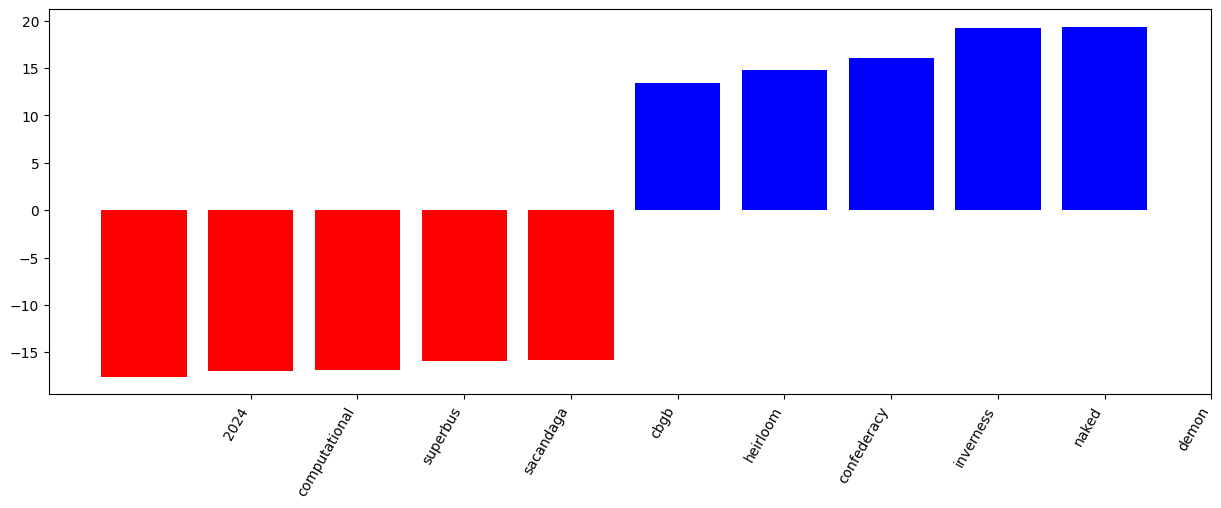

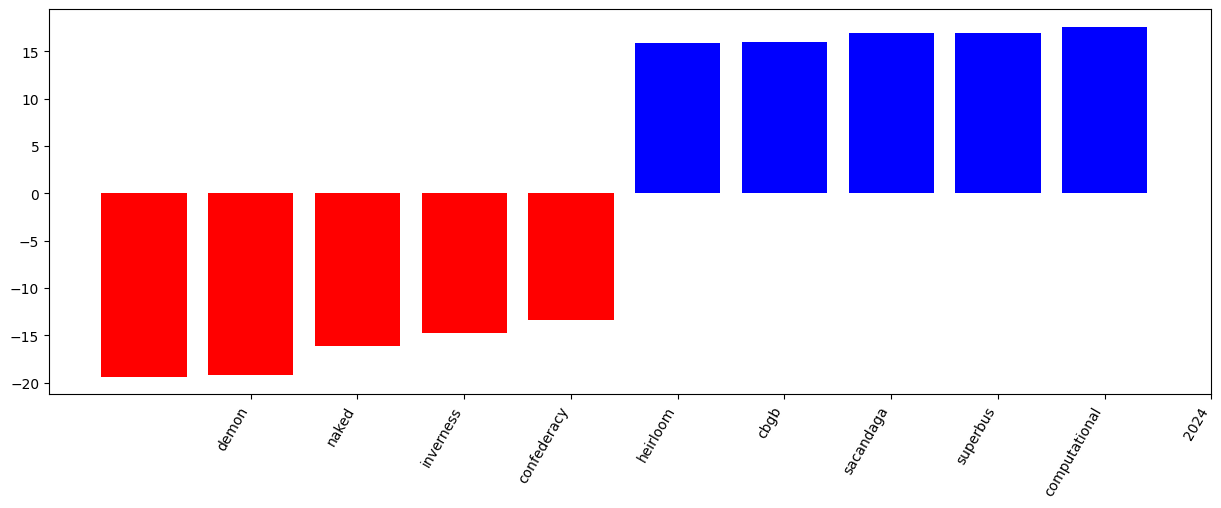

In [20]:
top_features = 5
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = clf.coef_

for i, cls in enumerate(clf.classes_): # for each of the classes
  coef = all_class_coef[0]
  if i == 0 :
    coef = coef * -1
  # find the top negative and positive features for the class
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  # combine them in one array
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot - humans tend to understand better plot visualizations
  feature_names = CountVec.get_feature_names()
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()


In [21]:
# get the probability of the model
valid_pred_prob = clf.predict_proba(X_val)

In [22]:
len(valid_pred_prob)

990

In [23]:
vpp_1 = valid_pred_prob[495:]
vpp_0 = valid_pred_prob[:495]

In [49]:
label1s = []
for index in range(len(vpp_1)):
    if val_pred[index] != y_val[index]:
        label1s.append([dfv.question_text.values[index],dfv.document_plaintext.values[index],vpp_1[index],val_pred[index]])

In [50]:
label0s = []
for index in range(len(vpp_0)):
    if val_pred[index+len(vpp_1)] != y_val[index+len(vpp_1)]:
        label0s.append([dfv.question_text.values[index+len(vpp_1)],dfv.document_plaintext.values[index+len(vpp_1)],vpp_0[index],val_pred[index+len(vpp_1)]])

In [52]:
label0s

[['What is a way to increase your wound healing speed?',
  'The etymology of the term scarless wound healing has a long history.[86][87][88] In print the antiquated concept of scarless healing was brought up the early 20th century and appeared in a paper published in the London Lancet. This process involved cutting in a surgical slant, instead of a right angle…; it was described in various Newspapers.',
  array([9.99191355e-01, 8.08644644e-04]),
  1],
 ['Who founded the Burntisland Shipbuilding Company?',
  'Burntisland\'s first three vessels were standard "C" type cargo ships[1] of just over 3,100 GRT each for the UK Government\'s wartime Shipping Controller, laid down in 1918 as hull numbers 101, 102 and 103.[3] They were launched in 1919 after the Armistice: hull 101 in June as War Brosna, 102 in September as War Dodder and 103 in November as War Tolka.',
  array([1.50364454e-09, 9.99999998e-01]),
  1],
 ['When was the first automated pool cleaner developed?',
  'An automated pool c

In [51]:
label1s

[['What is a way to increase your wound healing speed?',
  "Wound care encourages and speeds wound healing via cleaning and protection from reinjury or infection. Depending on each patient's needs, it can range from the simplest first aid to entire nursing specialties such as wound, ostomy, and continence nursing and burn center care.",
  array([0.29082869, 0.70917131]),
  0],
 ['What is the surface area of the human cortex?',
  'For species of mammals, larger brains (in absolute terms, not just in relation to body size) tend to have thicker cortices.[6] The smallest mammals, such as shrews, have a neocortical thickness of about 0.5mm; the ones with the largest brains, such as humans and fin whales, have thicknesses of 2.3–2.8mm. There is an approximately logarithmic relationship between brain weight and cortical thickness.[6]\nMagnetic resonance imaging of the brain (MRI) makes it possible to get a measure for the thickness of the human cerebral cortex and relate it to other measures.